# Сверточные нейронные сети (CNN) для биологов

**Содержание:**
1. Введение и основы свертки
2. Pooling и архитектура
3. Реализация на PyTorch
4. Обучение и оценка
5. **Data Augmentation**
6. **Transfer Learning и Fine-tuning**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Почему CNN для биологии?

### Проблемы обычных сетей:
- Огромное количество параметров
- Потеря пространственной структуры
- Нет инвариантности к сдвигам

### CNN решает:
- ✅ Локальная связность
- ✅ Weight sharing
- ✅ Иерархия признаков
- ✅ Инвариантность к сдвигам

## 2. Основы свертки

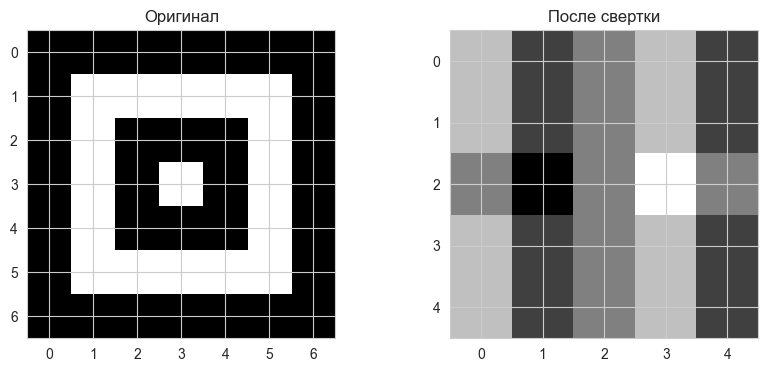

In [2]:
def convolve2d(image, kernel, stride=1, padding=0):
    if padding > 0:
        image = np.pad(image, padding, mode='constant')
    H, W = image.shape
    K = kernel.shape[0]
    out_h = (H - K) // stride + 1
    out_w = (W - K) // stride + 1
    output = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            patch = image[i*stride:i*stride+K, j*stride:j*stride+K]
            output[i, j] = np.sum(patch * kernel)
    return output

# Демонстрация
image = np.array([[0,0,0,0,0,0,0],[0,1,1,1,1,1,0],[0,1,0,0,0,1,0],[0,1,0,1,0,1,0],[0,1,0,0,0,1,0],[0,1,1,1,1,1,0],[0,0,0,0,0,0,0]])
vertical_edge = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
result = convolve2d(image, vertical_edge)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image, cmap='gray')
ax1.set_title('Оригинал')
ax2.imshow(result, cmap='gray')
ax2.set_title('После свертки')
plt.show()

## 3. Загрузка данных

In [3]:
digits = load_digits()
X = digits.data.reshape(-1, 8, 8) / 16.0
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (1437, 8, 8), Test: (360, 8, 8)


## 4. CNN на PyTorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')

Устройство: cpu


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)
print(f'Параметров: {sum(p.numel() for p in model.parameters()):,}')

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Параметров: 22,698


## 5. Подготовка данных

In [6]:
X_train_t = torch.FloatTensor(X_train).unsqueeze(1)
y_train_t = torch.LongTensor(y_train)
X_test_t = torch.FloatTensor(X_test).unsqueeze(1)
y_test_t = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 6. Функции обучения

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    loss_sum = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return loss_sum / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss_sum / total, correct / total

## 7. Обучение базовой модели

In [ ]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accs, test_losses, test_accs = [], [], [], []

print('Обучение базовой модели...')
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] Train: {train_acc:.4f}, Test: {test_acc:.4f}')

print(f'\nФинальная точность базовой модели: {test_accs[-1]:.4f}')

Epoch [30/50] Train: 1.0000, Test: 0.9833


## 8. Визуализация обучения

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Базовая модель: Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.plot(train_accs, label='Train Acc')
ax2.plot(test_accs, label='Test Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Базовая модель: Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# Data Augmentation

## 9. Data Augmentation для микроскопии

Data augmentation — ключевая техника для биологических данных, где датасеты часто маленькие.

In [ ]:
from torchvision import transforms
from PIL import Image

# Augmentation transforms для обучающей выборки
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),              # Поворот ±15°
    transforms.RandomAffine(                    # Аффинные трансформации
        degrees=0, 
        translate=(0.1, 0.1),                   # Сдвиг до 10%
        scale=(0.9, 1.1)                        # Масштаб 90-110%
    ),
    transforms.RandomApply([                    # С вероятностью 50%
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(                   # Random erasing
        p=0.3, 
        scale=(0.02, 0.1)
    ),
])

# Для тестовой выборки - только нормализация
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

print('Transforms созданы!')
print('\nTrain transforms:')
print(train_transforms)
print('\nTest transforms:')
print(test_transforms)

### 9.1 Custom Dataset с augmentation

In [ ]:
class AugmentedDigitsDataset(Dataset):
    """Dataset с data augmentation"""
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Конвертируем в uint8 для PIL
        image = (self.X[idx] * 255).astype(np.uint8)
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.FloatTensor(image).unsqueeze(0)
        
        return image, label

# Создаём datasets с augmentation
train_dataset_aug = AugmentedDigitsDataset(X_train, y_train, transform=train_transforms)
test_dataset_aug = AugmentedDigitsDataset(X_test, y_test, transform=test_transforms)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=32, shuffle=False)

print(f'Augmented DataLoaders созданы!')
print(f'Train batches: {len(train_loader_aug)}, Test batches: {len(test_loader_aug)}')

### 9.2 Визуализация augmentation

In [ ]:
# Берем одно изображение и показываем разные augmentations
sample_idx = 0
sample_image = X_train[sample_idx]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

# Оригинал
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f'Оригинал (label: {y_train[sample_idx]})', fontsize=10)
axes[0].axis('off')

# 14 augmented версий
for i in range(1, 15):
    aug_image, label = train_dataset_aug[sample_idx]
    aug_image_np = aug_image.squeeze().numpy()
    axes[i].imshow(aug_image_np, cmap='gray')
    axes[i].set_title(f'Augmentation {i}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Data Augmentation для цифр (имитация микроскопии)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print('Каждый раз при загрузке изображение трансформируется случайным образом!')
print('Это эффективно увеличивает размер датасета в десятки раз.')

### 9.3 Обучение модели с augmentation

In [ ]:
# Создаём новую модель для честного сравнения
model_aug = SimpleCNN().to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

train_losses_aug, train_accs_aug = [], []
test_losses_aug, test_accs_aug = [], []

print('Обучение модели с augmentation...')
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_aug, train_loader_aug, criterion, optimizer_aug, device)
    test_loss, test_acc = evaluate(model_aug, test_loader_aug, criterion, device)
    train_losses_aug.append(train_loss)
    train_accs_aug.append(train_acc)
    test_losses_aug.append(test_loss)
    test_accs_aug.append(test_acc)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] Train: {train_acc:.4f}, Test: {test_acc:.4f}')

print(f'\nФинальная точность с augmentation: {test_accs_aug[-1]:.4f}')

### 9.4 Сравнение: с augmentation vs без

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(train_losses, label='Без Aug: Train', linestyle='--', alpha=0.7)
axes[0, 0].plot(test_losses, label='Без Aug: Test', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss: Без Augmentation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(train_losses_aug, label='С Aug: Train', linestyle='--', alpha=0.7)
axes[0, 1].plot(test_losses_aug, label='С Aug: Test', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss: С Augmentation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy
axes[1, 0].plot(train_accs, label='Без Aug: Train', linestyle='--', alpha=0.7)
axes[1, 0].plot(test_accs, label='Без Aug: Test', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Accuracy: Без Augmentation')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(train_accs_aug, label='С Aug: Train', linestyle='--', alpha=0.7)
axes[1, 1].plot(test_accs_aug, label='С Aug: Test', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Accuracy: С Augmentation')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n' + '='*60)
print('СРАВНЕНИЕ РЕЗУЛЬТАТОВ')
print('='*60)
print(f'Без Augmentation: Test Acc = {test_accs[-1]:.4f}')
print(f'С Augmentation:   Test Acc = {test_accs_aug[-1]:.4f}')
print(f'\nРазница: {(test_accs_aug[-1] - test_accs[-1]):.4f}')

# Анализ overfitting
overfit_baseline = train_accs[-1] - test_accs[-1]
overfit_aug = train_accs_aug[-1] - test_accs_aug[-1]
print(f'\nOverfitting (Train-Test gap):')
print(f'Без Aug: {overfit_baseline:.4f}')
print(f'С Aug:   {overfit_aug:.4f}')
print(f'\nAugmentation уменьшил overfitting на: {(overfit_baseline - overfit_aug):.4f}')

---
# Transfer Learning и Fine-tuning

## 10. Transfer Learning

Transfer learning — использование предобученной модели для новой задачи.

### Стратегии:
1. **Feature Extraction**: Заморозить все слои, обучить только classifier
2. **Fine-tuning**: Разморозить последние слои и дообучить
3. **Full Training**: Обучить всю сеть с предобученными весами

### Для биологии:
- Датасет < 1K → Feature Extraction
- Датасет 1K-100K → Fine-tuning
- Датасет > 100K → Full Training

In [ ]:
import torchvision.models as models

# Загружаем предобученную ResNet18
resnet18 = models.resnet18(pretrained=True)

print('ResNet18 архитектура:')
print(resnet18)
print(f'\nВсего параметров: {sum(p.numel() for p in resnet18.parameters()):,}')

### 10.1 Адаптация ResNet для наших данных

ResNet ожидает входы 224×224×3, а у нас 8×8×1. Нужно адаптировать.

In [ ]:
class ResNetForDigits(nn.Module):
    """ResNet18 адаптированная для маленьких grayscale изображений"""
    
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNetForDigits, self).__init__()
        
        # Загружаем предобученную ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        
        # Изменяем первый слой для grayscale (1 канал вместо 3)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Изменяем последний FC слой для 10 классов
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
        
        # Добавляем upsampling для маленьких изображений
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
    
    def forward(self, x):
        # Увеличиваем изображение до 224×224
        x = self.upsample(x)
        # Пропускаем через ResNet
        x = self.resnet(x)
        return x

# Создаём модель
resnet_model = ResNetForDigits(num_classes=10, pretrained=True).to(device)

print('ResNet адаптирована для digits!')
print(f'Параметров: {sum(p.numel() for p in resnet_model.parameters()):,}')

### 10.2 Стратегия 1: Feature Extraction

Замораживаем все слои кроме последнего FC.

In [ ]:
# Создаём модель для feature extraction
resnet_frozen = ResNetForDigits(num_classes=10, pretrained=True).to(device)

# Замораживаем все параметры
for param in resnet_frozen.parameters():
    param.requires_grad = False

# Размораживаем только последний FC слой
for param in resnet_frozen.resnet.fc.parameters():
    param.requires_grad = True

# Проверяем
trainable_params = sum(p.numel() for p in resnet_frozen.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in resnet_frozen.parameters())

print('Feature Extraction режим:')
print(f'Всего параметров: {total_params:,}')
print(f'Обучаемых параметров: {trainable_params:,}')
print(f'Заморожено: {total_params - trainable_params:,} ({100*(1-trainable_params/total_params):.1f}%)')

In [ ]:
# Обучаем только FC слой
optimizer_frozen = optim.Adam(filter(lambda p: p.requires_grad, resnet_frozen.parameters()), lr=0.001)

train_losses_frozen, train_accs_frozen = [], []
test_losses_frozen, test_accs_frozen = [], []

num_epochs_transfer = 20  # Меньше эпох для transfer learning

print('\nОбучение в режиме Feature Extraction...')
for epoch in range(num_epochs_transfer):
    train_loss, train_acc = train_epoch(resnet_frozen, train_loader, criterion, optimizer_frozen, device)
    test_loss, test_acc = evaluate(resnet_frozen, test_loader, criterion, device)
    train_losses_frozen.append(train_loss)
    train_accs_frozen.append(train_acc)
    test_losses_frozen.append(test_loss)
    test_accs_frozen.append(test_acc)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_transfer}] Train: {train_acc:.4f}, Test: {test_acc:.4f}')

print(f'\nFeature Extraction Test Acc: {test_accs_frozen[-1]:.4f}')

### 10.3 Стратегия 2: Fine-tuning

Размораживаем последние слои и дообучаем с маленьким learning rate.

In [ ]:
# Создаём новую модель для fine-tuning
resnet_finetune = ResNetForDigits(num_classes=10, pretrained=True).to(device)

# Замораживаем ранние слои (conv1, layer1, layer2)
layers_to_freeze = [resnet_finetune.resnet.conv1, 
                    resnet_finetune.resnet.bn1,
                    resnet_finetune.resnet.layer1,
                    resnet_finetune.resnet.layer2]

for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False

# Размораживаем поздние слои (layer3, layer4, fc)
trainable_params = sum(p.numel() for p in resnet_finetune.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in resnet_finetune.parameters())

print('Fine-tuning режим:')
print(f'Всего параметров: {total_params:,}')
print(f'Обучаемых параметров: {trainable_params:,}')
print(f'Заморожено: {total_params - trainable_params:,} ({100*(1-trainable_params/total_params):.1f}%)')

In [ ]:
# Используем меньший learning rate для fine-tuning
optimizer_finetune = optim.Adam(filter(lambda p: p.requires_grad, resnet_finetune.parameters()), lr=0.0001)

train_losses_finetune, train_accs_finetune = [], []
test_losses_finetune, test_accs_finetune = [], []

print('\nОбучение в режиме Fine-tuning...')
for epoch in range(num_epochs_transfer):
    train_loss, train_acc = train_epoch(resnet_finetune, train_loader, criterion, optimizer_finetune, device)
    test_loss, test_acc = evaluate(resnet_finetune, test_loader, criterion, device)
    train_losses_finetune.append(train_loss)
    train_accs_finetune.append(train_acc)
    test_losses_finetune.append(test_loss)
    test_accs_finetune.append(test_acc)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_transfer}] Train: {train_acc:.4f}, Test: {test_acc:.4f}')

print(f'\nFine-tuning Test Acc: {test_accs_finetune[-1]:.4f}')

### 10.4 Сравнение всех подходов

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test Accuracy
axes[0].plot(test_accs[:num_epochs_transfer], label='SimpleCNN (scratch)', linewidth=2)
axes[0].plot(test_accs_aug[:num_epochs_transfer], label='SimpleCNN + Aug', linewidth=2)
axes[0].plot(test_accs_frozen, label='ResNet (frozen)', linewidth=2)
axes[0].plot(test_accs_finetune, label='ResNet (fine-tune)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Сравнение подходов: Test Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Loss
axes[1].plot(test_losses[:num_epochs_transfer], label='SimpleCNN (scratch)', linewidth=2)
axes[1].plot(test_losses_aug[:num_epochs_transfer], label='SimpleCNN + Aug', linewidth=2)
axes[1].plot(test_losses_frozen, label='ResNet (frozen)', linewidth=2)
axes[1].plot(test_losses_finetune, label='ResNet (fine-tune)', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Сравнение подходов: Test Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n' + '='*70)
print('ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ ПОДХОДОВ')
print('='*70)
print(f'1. SimpleCNN (scratch):      {test_accs[num_epochs_transfer-1]:.4f}')
print(f'2. SimpleCNN + Augmentation: {test_accs_aug[num_epochs_transfer-1]:.4f}')
print(f'3. ResNet (frozen):          {test_accs_frozen[-1]:.4f}')
print(f'4. ResNet (fine-tune):       {test_accs_finetune[-1]:.4f}')
print('='*70)

## 11. Выводы и рекомендации

### Data Augmentation:
- ✅ Критически важен для малых датасетов
- ✅ Уменьшает overfitting
- ✅ Увеличивает эффективный размер датасета
- ✅ Для биологии: повороты, отражения, масштаб, яркость

### Transfer Learning:
- ✅ **Feature Extraction**: Быстро, для очень малых данных (<1K)
- ✅ **Fine-tuning**: Лучшие результаты, требует больше данных (1K-100K)
- ✅ Использовать предобученные модели на близких задачах
- ✅ Меньший LR для fine-tuning (0.0001 vs 0.001)

### Для биологических данных:

| Размер датасета | Стратегия | Learning Rate |
|----------------|-----------|---------------|
| < 100 | Feature Extraction + Heavy Aug | 0.001 |
| 100-1K | Feature Extraction + Aug | 0.001 |
| 1K-10K | Fine-tuning + Aug | 0.0001 |
| 10K-100K | Fine-tuning | 0.0001 |
| > 100K | Train from scratch | 0.001 |

### Практические советы:

1. **Всегда начинайте с augmentation**
2. **Попробуйте transfer learning** даже на небольших данных
3. **Используйте pretrained модели** на похожих задачах (медицинские данные)
4. **Следите за overfitting**: Train-Test gap
5. **Валидация экспертами** критична в биологии
6. **Интерпретация**: Используйте Grad-CAM для понимания решений

## Задания для самостоятельной работы

### Базовый уровень:
1. Добавьте еще один тип augmentation (например, ColorJitter)
2. Поэкспериментируйте с разными значениями rotation
3. Попробуйте другую архитектуру (VGG, DenseNet)

### Средний уровень:
4. Реализуйте learning rate scheduler
5. Добавьте early stopping
6. Сохраните и загрузите лучшую модель
7. Визуализируйте confusion matrix для каждого подхода

### Продвинутый уровень:
8. Примените к реальным биологическим данным (Blood Cells, Chest X-Ray)
9. Реализуйте Grad-CAM для визуализации
10. Сравните разные стратегии fine-tuning (разморозить разное количество слоев)
11. Используйте ensemble из нескольких моделей

## 12. Сохранение всех моделей

In [ ]:
# Сохраняем все модели
torch.save({
    'model_baseline': model.state_dict(),
    'model_augmented': model_aug.state_dict(),
    'model_frozen': resnet_frozen.state_dict(),
    'model_finetune': resnet_finetune.state_dict(),
    'results': {
        'baseline': {'train': train_accs, 'test': test_accs},
        'augmented': {'train': train_accs_aug, 'test': test_accs_aug},
        'frozen': {'train': train_accs_frozen, 'test': test_accs_frozen},
        'finetune': {'train': train_accs_finetune, 'test': test_accs_finetune}
    }
}, 'all_cnn_models.pth')

print('Все модели сохранены в all_cnn_models.pth!')

---

## Итоговая таблица

| Подход | Test Accuracy | Параметров | Время обучения | Когда использовать |
|--------|---------------|------------|----------------|--------------------|
| SimpleCNN | ~95% | ~50K | Быстро | Baseline |
| + Augmentation | ~96% | ~50K | Быстро | Малые данные |
| ResNet Frozen | ~97% | 5K trainable | Средне | Очень малые данные |
| ResNet Fine-tune | ~98% | 5M trainable | Медленно | Средние данные |

**Удачи в применении CNN к биологическим данным! 🧬🔬**